In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np

In [2]:
load_dotenv(override=True)
api_key = os.getenv('KAGGLE_API_TOKEN')


In [3]:
from pathlib import Path
import zipfile,kaggle
path = Path('titanic')
if not path.exists():
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [4]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [5]:
# add additional features
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(train_df)
add_features(test_df)

In [6]:
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2.110213,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,ABC,1,False,1,Mrs


In [7]:
# select features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck', 'Family', 'Alone', 'TicketFreq', 'Title', 'LogFare']
target = 'Survived'

In [8]:
# split X and y (train only)
X = train_df[features]
y = train_df[target]

print(X.shape)
print(y.shape)

(891, 13)
(891,)


#### Pre processing

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [10]:
train_df[features].dtypes

Pclass          int64
Sex               str
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked          str
Deck              str
Family          int64
Alone            bool
TicketFreq      int64
Title             str
LogFare       float64
dtype: object

In [11]:
numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family', 'TicketFreq', 'LogFare']
categorical_features = ['Sex', 'Embarked', 'Deck', 'Title']

In [12]:
from sklearn.impute import SimpleImputer

# numeric transformer
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
    ])

In [13]:
# categorical transformer
categorical_transformer = Pipeline(steps=[
("imputer", SimpleImputer(strategy="most_frequent")),
("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [14]:
# combine transformers ready for application
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [15]:
# split X and y (train only)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

In [17]:
X_train_processed.shape, X_val_processed.shape

((712, 20), (179, 20))

In [18]:
# convert labels to Numpy arrays for y
y_train = y_train.values
y_val = y_val.values

#### Pytorch

In [19]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [20]:
# convert arrays to pytorch tensors

In [21]:
X_train_tensor = torch.tensor(X_train_processed.astype(np.float32))
X_val_tensor = torch.tensor(X_val_processed.astype(np.float32))

In [22]:
y_train_tensor = torch.tensor(y_train.astype(np.int64))
y_val_tensor = torch.tensor(y_val.astype(np.int64))

In [23]:
print(X_train_tensor.shape, X_val_tensor.shape)
print(y_train_tensor.shape, y_val_tensor.shape)

torch.Size([712, 20]) torch.Size([179, 20])
torch.Size([712]) torch.Size([179])


In [56]:
# binary classifier; 3 layers; ReLu activations, output 1 neuron
class TitanicNet(nn.Module):
    # init
    def __init__(self, input_dim):
        super(TitanicNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    
    # forward pass
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # No sigmoid; BCEWithLogitsLoss applies it
        return x

In [57]:
# instantiate the model
input_dim = X_train_tensor.shape[1]
model = TitanicNet(input_dim)
print(model)

TitanicNet(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


In [58]:
# loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.95)

In [59]:
# training params
epochs = 50
batch_size = 32

In [60]:
# manually slice batches
def get_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size].unsqueeze(1)

#### Training Loop

In [61]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in get_batches(X_train_tensor, y_train_tensor, batch_size):
        optimizer.zero_grad() # clear previous gradients
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(X_train_tensor)

    # Validation
    model.eval() # set to eval mode
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor.unsqueeze(1).float())
        val_pred_labels = torch.sigmoid(val_pred) > 0.5
        val_acc = (val_pred_labels.squeeze() == y_val_tensor).float().mean()
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/50 | Train Loss: 0.6576 | Val Loss: 0.6416 | Val Acc: 0.6145
Epoch 2/50 | Train Loss: 0.6151 | Val Loss: 0.5976 | Val Acc: 0.6201
Epoch 3/50 | Train Loss: 0.5438 | Val Loss: 0.5210 | Val Acc: 0.7486
Epoch 4/50 | Train Loss: 0.4638 | Val Loss: 0.4608 | Val Acc: 0.7765
Epoch 5/50 | Train Loss: 0.4321 | Val Loss: 0.4336 | Val Acc: 0.8156
Epoch 6/50 | Train Loss: 0.4243 | Val Loss: 0.4263 | Val Acc: 0.8324
Epoch 7/50 | Train Loss: 0.4102 | Val Loss: 0.4256 | Val Acc: 0.8380
Epoch 8/50 | Train Loss: 0.4010 | Val Loss: 0.4219 | Val Acc: 0.8380
Epoch 9/50 | Train Loss: 0.3943 | Val Loss: 0.4193 | Val Acc: 0.8324
Epoch 10/50 | Train Loss: 0.3889 | Val Loss: 0.4174 | Val Acc: 0.8380
Epoch 11/50 | Train Loss: 0.3847 | Val Loss: 0.4163 | Val Acc: 0.8380
Epoch 12/50 | Train Loss: 0.3813 | Val Loss: 0.4154 | Val Acc: 0.8436
Epoch 13/50 | Train Loss: 0.3784 | Val Loss: 0.4144 | Val Acc: 0.8380
Epoch 14/50 | Train Loss: 0.3753 | Val Loss: 0.4139 | Val Acc: 0.8492
Epoch 15/50 | Train Loss: 0.3

#### Run again but with losses plotted

In [77]:
# Re-initialize model
model = TitanicNet(input_dim)

# Re-initialize loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

In [78]:
epochs = 50
batch_size = 32

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in get_batches(X_train_tensor, y_train_tensor, batch_size):
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(X_train_tensor)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor.unsqueeze(1).float())
        val_losses.append(val_loss.item())
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/50 | Train Loss: 0.7010 | Val Loss: 0.6691
Epoch 2/50 | Train Loss: 0.6412 | Val Loss: 0.6285
Epoch 3/50 | Train Loss: 0.5983 | Val Loss: 0.5988
Epoch 4/50 | Train Loss: 0.5572 | Val Loss: 0.5622
Epoch 5/50 | Train Loss: 0.5160 | Val Loss: 0.5265
Epoch 6/50 | Train Loss: 0.4801 | Val Loss: 0.4953
Epoch 7/50 | Train Loss: 0.4532 | Val Loss: 0.4695
Epoch 8/50 | Train Loss: 0.4344 | Val Loss: 0.4515
Epoch 9/50 | Train Loss: 0.4213 | Val Loss: 0.4409
Epoch 10/50 | Train Loss: 0.4122 | Val Loss: 0.4343
Epoch 11/50 | Train Loss: 0.4055 | Val Loss: 0.4297
Epoch 12/50 | Train Loss: 0.4001 | Val Loss: 0.4260
Epoch 13/50 | Train Loss: 0.3955 | Val Loss: 0.4232
Epoch 14/50 | Train Loss: 0.3915 | Val Loss: 0.4210
Epoch 15/50 | Train Loss: 0.3880 | Val Loss: 0.4194
Epoch 16/50 | Train Loss: 0.3848 | Val Loss: 0.4183
Epoch 17/50 | Train Loss: 0.3816 | Val Loss: 0.4171
Epoch 18/50 | Train Loss: 0.3789 | Val Loss: 0.4162
Epoch 19/50 | Train Loss: 0.3765 | Val Loss: 0.4152
Epoch 20/50 | Train L

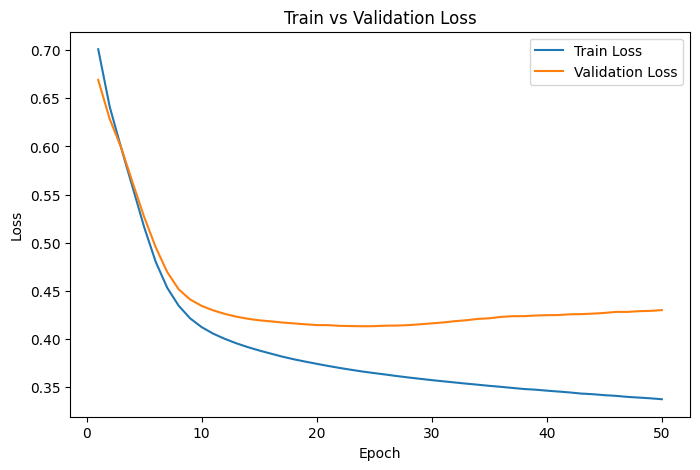

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()